# Practical 3

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cvxopt  # needed later on

# Task 0: Preliminaries

This time we will work with a synthetic 2d dataset to facilitate visualization and be able to focus on the algorithms rather than spending energy to understand the dataset. The dataset consists of two classes and two predictors. Below we load the dataset and plot it.

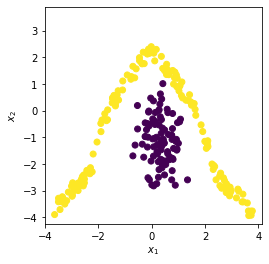

In [2]:
X_2d, t_2d = np.load('nonlin_2d_data.npy')[:, :2], np.load('nonlin_2d_data.npy')[:, 2]

plt.scatter(X_2d[:, 0], X_2d[:, 1], c=t_2d)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('square');

### Task 0.1

Apply logistic regression and LDA to the provided data, compute classification accuracy and plot the predictions. How do they perform? You're welcome to use sklearn for this task.

In [3]:
from sklearn.linear_model import LogisticRegression

In [4]:
# Split data in training and test set
def split_data(X, y, frac=0.3, s=None):
    if s is not None:
        np.random.seed(s)

    # ---------------- INSERT CODE ----------------------
    idx = X.shape[0]

    n_trainset = int(idx*(1-frac))  # size of the training set
    n_testset = idx-n_trainset  # size of the test set

    idx_shuffled = np.random.permutation(idx)

    test_idx = idx_shuffled[:n_testset]
    train_idx = idx_shuffled[n_testset:n_testset+n_trainset]

    X_test = X[test_idx]
    y_test = y[test_idx]
    print('Test set shapes (X and y)', X_test.shape, y_test.shape)

    X_train = X[train_idx]
    y_train = y[train_idx]
    print('Training set shapes (X and y):', X_train.shape, y_train.shape)
    

    # ---------------- END CODE -------------------------
    
    return X_train, X_test, y_train, y_test

X_train, X_test, t_train, t_test = split_data(X_2d, t_2d, s=1)

Test set shapes (X and y) (75, 2) (75,)
Training set shapes (X and y): (175, 2) (175,)


In [5]:
# Logistic Regression

clf = LogisticRegression(random_state=0).fit(X_train, t_train)

print(
    "Score on Train: \n",
    clf.score(X_train,t_train),
    "\nScore on Test:\n",
    clf.score(X_test,t_test)
)

Score on Train: 
 0.6 
Score on Test:
 0.6


In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [7]:
# LDA
clf = LinearDiscriminantAnalysis().fit(X_train, t_train)

print(
    "Score on Train: \n",
    clf.score(X_train,t_train),
    "\nScore on Test:\n",
    clf.score(X_test,t_test)
)

Score on Train: 
 0.6 
Score on Test:
 0.6


### Task 0.2

Implement the Gaussian RBF and visualize the pairwise similarities of `x`.

In [8]:
x = np.stack([np.sin(np.linspace(0, 8, 15)), np.cos(np.linspace(0, 7, 15))]).T


In [9]:
# RBF kernel
RBF = lambda x,y,gamma=1 : np.exp(gamma*np.sqrt(np.sum((x - y)**2)))

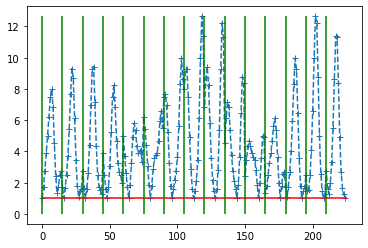

In [10]:
# Visualize pairwise similarities

pairwise_simularity = []
# calculating the simularity for each point to each point -> simularity to itself should be 1 -> In diagram one should go from left to right 
for point1 in x:
    for point2 in x:
        similarity = RBF(point1,point2)
        pairwise_simularity.append(similarity)

pairwise_simularity = np.array(pairwise_simularity)
# pairwise_simularity.reshape(15,15)

plt.plot(pairwise_simularity,marker='+',linestyle='--')
plt.hlines(1,0,15*15, colors="red")
plt.vlines([15*i for i in range(15)],0,pairwise_simularity.max(),colors='green')
plt.show()

# Task 1: Kernel Discriminant Analysis

We will be implementing Kernel Discriminant Analysis, a nonlinear extension to LDA based on the kernel trick, following the original paper by Mika, Rätsch, Weston, Schölkopf and Müller (PDF on StudIP). Note, this is the original notation from the paper, mind the difference betweeen the matrix $M$ and the vectors $M_1, M_2$.

The goal of Kernel Discriminant Analysis is find a vector of $\alpha$'s that maximizes
$$ J(\alpha) = \frac{\alpha^T M \alpha}{\alpha^T N \alpha} $$
where
$$ M := (M_1 - M_2)(M_1 - M_2)^T \text{ with } (M_i)_j = \frac{1}{l_i} \sum_{k=1}^{l_i} \mbox{k}(x_j, x_k^i) $$ and
$$N= \sum_{j=1,2} K_j (I - 1_{l_j}) K_j^T$$
Here, the number of samples for class $j$ is denoted by $l_j$. In the definition of $N$, $(K_{j})_{n,m} = \mbox{k}(x_n, x_m^j)$, $I$ is the identity matrix and $1_{l_j}$ is a matrix with each entry equal to $1/l_j$. $M_1, M_2$ have shape $(l_0 + l_1)$ each, $N$ and $M$ have shape $(l_0 + l_1) \times (l_0 + l_1)$.

We obtain the optimal solution by $\alpha = N^{-1}(M_1 - M_0)$. Note that you may have to regularize $N^{-1}$ for numerical stability (see paper or Wikipedia).

Prediction for an arbitrary sample $x$ is then carried out by building a weighted sum over it's kernel with the samples from the training set.

1. Implement a function `kda(X, t, kernel)` that carries out Kernel Discriminant Analysis on the data $X,t$ and returns a vector `alpha`.
2. Implement a function `def predict(x, X, alpha, kernel)`.
3. Visualize results given a linear kernel and a Gaussian Radial Basis Function kernel.

Use the following snippet as a starting point.

In [18]:
def kda(X, t, kernel, verbose=False):
    l = [(t == 0).sum(), (t == 1).sum()]
    X_split = X[(t == 0)], X[(t == 1)]
    # ...
    # Calcualte K:
    K1 = np.array([kernel(p1,p2) for p1 in X for p2 in X_split[0]]).reshape(l[0]+l[1], l[0])
    K2 = np.array([kernel(p1,p2) for p1 in X for p2 in X_split[1]]).reshape(l[0]+l[1], l[1])
    
    # Calculate M
    M1 = 1/l[0]*np.sum(K1, axis = 1)
    M2 = 1/l[1]*np.sum(K2, axis = 1)
    M = np.outer((M1 - M2),(M1 - M2))
    
    # Calculate N:
    I = np.identity(l[0]+l[1])
    L1 = np.ones(l[0]+l[1]) * 1/l[0]
    L2 = np.ones(l[0]+l[1]) * 1/l[1]

    # Weaky transposing again
    N1 = K1 @ ((I-L1) @ K1).T
    N2 = K2 @ ((I-L2) @ K2).T
    N = N1 + N2
    
    #### alpha
    alpha = np.linalg.inv(N) @ (M2-M1)
    c = alpha @ (1/2 * (M1 + M2))
    
    if verbose:
        print("Shape of l1, l2: ", l[0], l[1])
        print("Shape of K1, K2: ", K1.shape, K2.shape)
        print("Shape of M1, M2: ", M1.shape, M2.shape)
        print("Shape of M: ", M.shape)
        print("Shape of N1, N2, N: ", N1.shape, N2.shape, N.shape )

    return alpha, c


def predict(x, X, alpha, kernel):
    K = np.array([kernel(p1,p2) for p1 in x for p2 in X]).reshape(X.shape[0], x.shape[0])
    result = K.T @ alpha
    return result


def linear_kernel(x_n, x_m):
    return x_n @ x_m


def rbf_kernel(x_n, x_m, gamma=5):
    return np.exp(gamma*np.sqrt(np.sum((x_n - x_m)**2)))

In [19]:
# Perform KDA with linear and RBF kernel

#with rbf
a ,c = kda(X_train, t_train, rbf_kernel, verbose=True)
test_predictions_rbf = predict(X_test, X_train, a, rbf_kernel)
train_predictions_rbf = predict(X_train, X_train, a, rbf_kernel)

#with linear
a_lin, c_lin = kda(X_train, t_train, linear_kernel)
test_predictions_linear = predict(X_test, X_train, a_lin, linear_kernel)
train_predictions_linear = predict(X_train, X_train, a_lin, linear_kernel)

# two colored with threshold c
test_predict_rbf_c = [1 if t>0.1 else 0 for t in test_predictions_rbf]
train_predict_rbf_c = [1 if t>0.1 else 0 for t in train_predictions_rbf]
test_predict_linear_c = [1 if t>c_lin else 0 for t in test_predictions_linear]
train_predict_linear_c = [1 if t>c_lin else 0 for t in train_predictions_linear]

Shape of l1, l2:  70 105
Shape of K1, K2:  (175, 70) (175, 105)
Shape of M1, M2:  (175,) (175,)
Shape of M:  (175, 175)
Shape of N1, N2, N:  (175, 175) (175, 175) (175, 175)


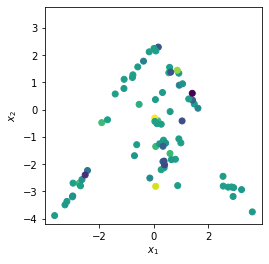

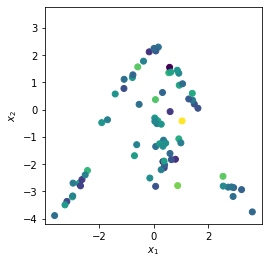

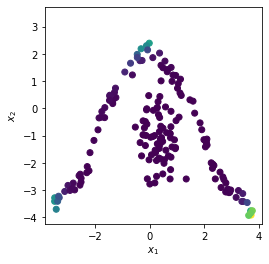

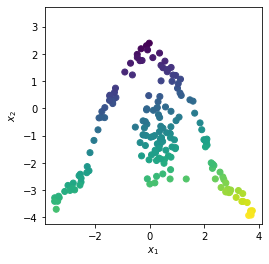

Again with a not right nice Threshold...


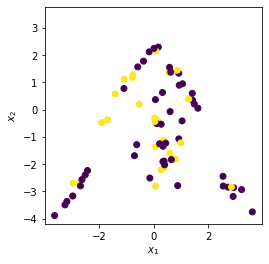

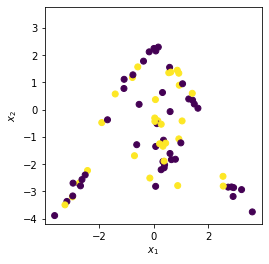

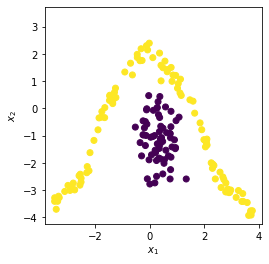

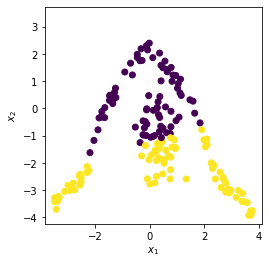

In [13]:
# Visualize results
plt.scatter(X_test[:,0], X_test[:, 1], c=test_predictions_rbf)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('square')
plt.show()

plt.scatter(X_test[:,0], X_test[:, 1], c=test_predictions_linear)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('square')
plt.show()

plt.scatter(X_train[:,0], X_train[:, 1], c=train_predictions_rbf)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('square')
plt.show()

plt.scatter(X_train[:,0], X_train[:, 1], c=train_predictions_linear)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('square')
plt.show()


print("Again with a not right nice Threshold...")
plt.scatter(X_test[:,0], X_test[:, 1], c=test_predict_rbf_c)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('square')
plt.show()

plt.scatter(X_test[:,0], X_test[:, 1], c=test_predict_linear_c)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('square')
plt.show()

plt.scatter(X_train[:,0], X_train[:, 1], c=train_predict_rbf_c)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('square')
plt.show()

plt.scatter(X_train[:,0], X_train[:, 1], c=train_predict_linear_c)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('square')
plt.show()



### Task 1.2

Which value would you use as a threshold to separate the classes? Use this threshold value to visualize the decision boundaries in a 2d grid (see example code below) and make predictions on the test set.

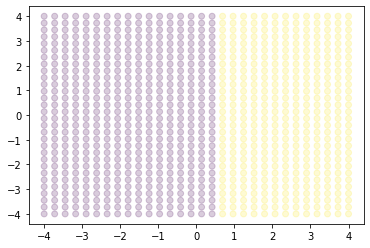

In [14]:
def plot_decision_boundary(predict_fn):
    ''' Plot decision boundary.

    predict_fn: function handle to a predict function that takes
                as input a data point x and outputs the predicted
                label t
    '''
    grid = np.meshgrid(np.linspace(-4, 4, 30), np.linspace(-4, 4, 30))
    grid_x, grid_y = grid[0].flatten(), grid[1].flatten()
    grid_t = np.array([
        predict_fn([x, y]) for x, y, in zip(grid_x, grid_y)])
    plt.scatter(grid_x, grid_y, c=grid_t, alpha=0.2)


# The following example has the decision boundary at x[0] = 0.5
predict_fn = lambda x: x[0] > 0.5
plot_decision_boundary(predict_fn)

In [15]:
#visualize descisson boundaries